# Introduction
We focus on ambulance diversions in the emergency department (ED) as a prototype example to illustrate how data-adaptive decision-making, via an AI-digital-twin integrated approach, can lead to better mortality outcomes during a healthcare crisis. Diverting ambulances aims to reduce ED overcrowding and balance patient load among multiple EDs. However, setting a static policy, such as diverting only when the number of patients in the ED (queue) exceeds a prespecified threshold, can be highly suboptimal during crisis situations, because the threshold used in normal situations can perform poorly in the latter cases. If we can adaptively change the threshold level by assimilating and optimizing according to the predicted surge, we could more effectively avoid overcrowding and potentially save lives. This simple prototype example showcases the mortality improvement using such a data-adaptive threshold policy. In particular, the optimization of this data-adaptive policy requires running system simulation for the mortality outcomes from each hospital. This simulation model resembles the proposed digital twins that are envisioned to build at a much larger scale. However, in this example, a simulation run of each trajectory to output the mortality outcome already takes ~4 hours on a computer with an Intel Core i5-8250U CPU and 8GB RAM. Optimizing an adaptive policy at each threshold-changing opportunity would require running a sufficient number (e.g., 100) of trajectories to wash out the simulation error, as well as evaluating a wider grid of threshold values for performance comparison, and hence would be computationally intractable. This motivates us to investigate a metamodeling of the digital twin via a computationally much lighter AI model that can be optimized more straightforwardly, thus leading to an overall AI-digital-twin integrative approach.

# Simulation Model
The simulation model consists of two emergency departments (labeled ED-1 and ED-2), each with their own physicians and patients. We model patient death time as a logistic function with parameters dependent on the patient’s triage level and wait time (see Figure 1), with slightly perturbed parameters for each patient. Data from [Lin et al (2014)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3950617/#Sec8), [Chowdhury et al (2018)](https://www.physicianleaders.org/articles/queuing-theory-reducing-wait-stay), and [Wrede et al (2020)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7699806/) were used to estimate average hourly arrival rates, triage probabilities, and service rates (physician times), which were assumed to only depend on the triage level (see Table 1). Arrival rates and service rates were assumed to be exponentially distributed. A weekday multiplier was also added to the arrival rate. 25% of arrivals were assumed to be by ambulance and the other 75% were assumed to be walk-ins. The same values were used for both emergency departments. 

According to the [American Academy of Emergency Medicine](https://www.aaem.org/statements/position-statement-on-emergency-physician-to-patient-ed-staffing-ratios/), there must be at least one physician for every 2.5 patients per hour. Based on the estimated hourly arrival rates, this requirement is satisfied by the physician schedule used for ED-1 below.

Physicians are assumed to begin serving any type of patient arriving between the start of their shift to the end of their shift (and so may finish after the end of their shift if they are still attending to a patient). Furthermore, they are assumed to serve the highest priority (triage level) patient in the queue, otherwise they will serve the first patient that arrives if the queue is empty. Finally, if a patient with a triage level of 1 arrives and all physicians are busy, the physician serving the lowest priority patient will stop and attend to the patient that has just arrived first, unless all physicians are serving patients with a triage level of 1.

In [1]:
import numpy as np
import pandas as pd 
from pickle import load
from functions import *

np.random.seed(3)
days = 4
thresholds = np.linspace(0, 200, 9)
hosp2_doctor_shift_counts = [2, 2, 4, 2, 4, 1] 
daily_crisis_factor = [1, 1, 1, 1] # normal scenario
assert(len(daily_crisis_factor) == days)
reps = 100
travel_time_between_hospitals = 10./60.

# Load saved models
with open('models/surrogate_model.pkl', 'rb') as f: 
    threshold_model = load(f)
with open('models/static_forecast_ARIMA.pkl', 'rb') as f: 
    static_forecast_ARIMA = load(f)

# set input parameters
hourly_arrival_rates = [3.12,2.54,2.33,2.33,2.63,3.21,4.61,6.73,9.08,11.46,11.76,10.97,11.25,10.27,11.46,11.36,11.08,10.43,10.04,9.57,8.31,7.03,5.12,5.05]
weekday_multiplier = [1.03, 0.97, 0.92, 0.94, 1., 1.06, 1.08]
hourly_arrival_rates = [h * weekday_multiplier[d % 7] * daily_crisis_factor[d] for d in range(days) for h in hourly_arrival_rates] + [0]
triage_probabilities = [0.0099, 0.0874, 0.4951, 0.3777, 0.0299] # highest to lowest priority
triage_probabilities_crisis = [0.1498, 0.2761, 0.3196, 0.2297, 0.0248] # crisis
service_rate = np.array([1.3, 1.25, 0.8, 0.45, 0.3]) # dependent on triage
patience = np.array([np.inf, np.inf, 6, 5, 4]) # dependent on triage
patients_hosp1 = generate_patients(hourly_arrival_rates, service_rate, patience, triage_probabilities, triage_probabilities_crisis, daily_crisis_factor, hosp_number=1)
patients_hosp2 = generate_patients(hourly_arrival_rates, service_rate, patience, triage_probabilities, triage_probabilities_crisis, daily_crisis_factor, hosp_number=2)

# save auxiliary variables
_patients_hosp1 = patients_hosp1
_patients_hosp2 = patients_hosp2
_hourly_arrival_rates = static_forecast_ARIMA.predict(24 * days)
_patients_hosp1_arrival_counts = get_patient_arrival_counts(_patients_hosp1)
_patients_hosp2_arrival_counts = get_patient_arrival_counts(_patients_hosp2)

##### Figure 1. CDF of patient death time at different triage levels. Each patient will have a slightly different mortality curve within an interval according to their triage. Patients leave the queue if they die or their patience runs out.

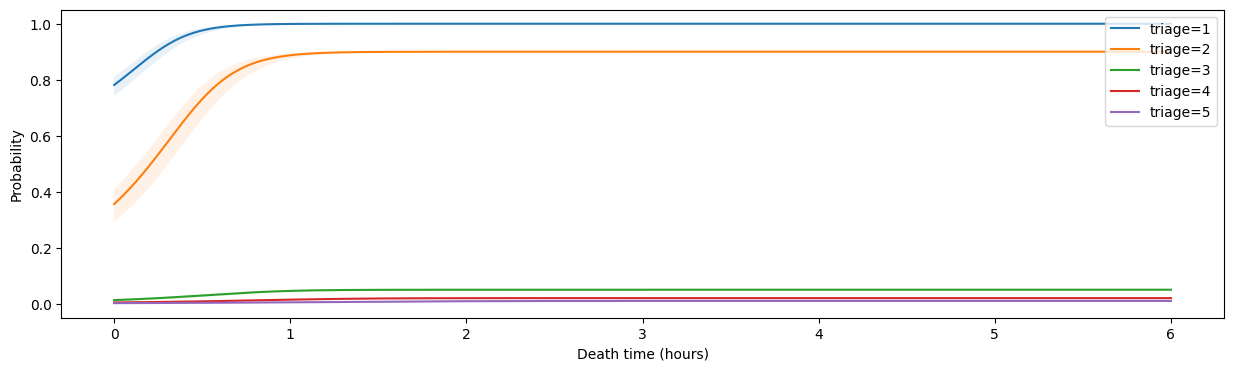

In [2]:
plot_mortality()

##### Figure 2. Actual (top) and forecasted (bottom) hourly arrival rate of patients over a four-day period.

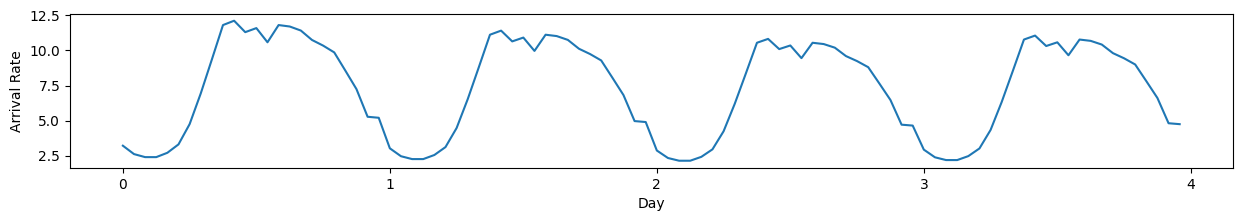

In [3]:
plot_arrival_rate(hourly_arrival_rates[:-1]) # actual arrival rates

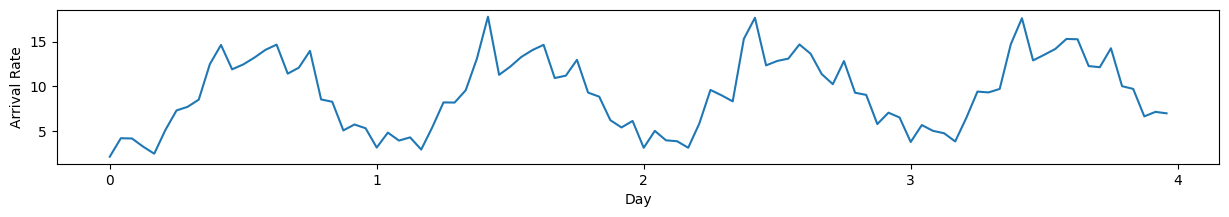

In [4]:
plot_arrival_rate(_hourly_arrival_rates) # predicted arrival rates

##### Table 1. Input parameters based on triage level.

In [5]:
pd.DataFrame({
    'Triage Level': [1, 2, 3, 4, 5], 
    'Proportion (Normal)': triage_probabilities, 
    'Proportion (Surge)': triage_probabilities_crisis, 
    'Service Rate': service_rate, 
    'Patience': patience
    })

,Triage Level,Proportion (Normal),Proportion (Surge),Service Rate,Patience
0,1,0.0099,0.1498,1.30,inf
1,2,0.0874,0.2761,1.25,inf
2,3,0.4951,0.3196,0.80,6.0
3,4,0.3777,0.2297,0.45,5.0
4,5,0.0299,0.0248,0.30,4.0


# Results

We first apply a static policy, using a single prespecified threshold value for the number of patients in ED-1’s queue which, if exceeded, leads to the diversion of all patients that would have arrived at ED-1 by ambulance to ED-2. We assume that this leads to an increase in travel time of five minutes. With knowledge of physician times and mortality rate curves, as well as forecasted hourly arrival rates, we can apply our simulation to a normal scenario over a four day period, with arrival rates seen in Figure 2, and a crisis scenario, where the arrival rate is tripled in the second and third days, with changes to triage level proportions as well (see Figure 4 and Table 1). The best threshold is 25 under the normal scenario (see Figure 5), which leads to a mortality rate of 25.20\%.

We then apply a data-adaptive threshold policy where thresholds can change at the beginning of each shift (i.e., every 4 hours) during the simulation period. To determine the optimal threshold at the start of each shift, we predict the arrival rate and repeatedly simulate ED arrivals until the end of our time horizon at a grid of threshold values, choosing the threshold that leads to the lowest mortality. Using this data-adaptive threshold policy, we obtain an improved mortality rate of 24.35\%, which is approximately 10 lives saved across both hospitals, during the surge scenario. For larger-scale problems, we expect more significant improvements in mortality outcomes, though simulation would be unable to achieve these improvements tractably.

To address the computational limitations of our simulation model, we construct a metamodel to estimate the optimal threshold at the start of each shift. Due to the computational cost of simulating long time periods, we reduced our simulation horizon to 4 days, with a surge occurring during days 2 and 3. We simulated scenarios with varying physician counts and surge arrival rates, using the data-adaptive policy to determine the optimal threshold at the beginning of each shift. A random forest model was then fitted to the simulated data using 10-fold cross-validation. The features used in the model include the number of patient arrivals in each of the previous six shifts (i.e., the previous day), the thresholds corresponding to each of the previous six shifts, and the number of physicians in each shift -- these are all known at the start of each shift. Results from Figure 6 indicate that this AI-digital-twin integrative approach improves upon the static policy in a similar way to the data-adaptive policy with a mortality rate of 24.72\%.

In [6]:
# setting parameters for crisis scenario
hosp2_doctor_shift_counts = [[2, 2, 4, 2, 4, 1]]
crisis_f = [3]
daily_crisis_factor = [[1, c, c, 1] for c in crisis_f]
hourly_arrival_rates = [3.12,2.54,2.33,2.33,2.63,3.21,4.61,6.73,9.08,11.46,11.76,10.97,11.25,10.27,11.46,11.36,11.08,10.43,10.04,9.57,8.31,7.03,5.12,5.05]
hourly_arrival_rates = [[h * weekday_multiplier[d % 7] * dcf[d] for d in range(days) for h in hourly_arrival_rates] + [0] for dcf in daily_crisis_factor]
patients_hosp1 = [generate_patients(har, service_rate, patience, triage_probabilities, triage_probabilities_crisis, dcf, hosp_number=1) for dcf, har in zip(daily_crisis_factor, hourly_arrival_rates)]
patients_hosp2 = [generate_patients(har, service_rate, patience, triage_probabilities, triage_probabilities_crisis, dcf, hosp_number=2) for dcf, har in zip(daily_crisis_factor, hourly_arrival_rates)]

##### Figure 4. Hourly arrival rate in the surge scenario where a surge in arrivals occurs in days 2 and 3.

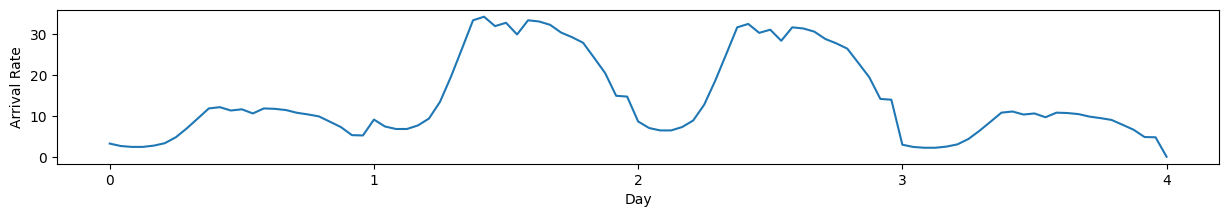

In [7]:
plot_arrival_rate(hourly_arrival_rates[0])

##### Figure 5. Mortality rate under the static policy at different thresholds (for the normal scenario).

Best Threshold: 25.0
Crisis Mortality Rate: 0.2519056261343013


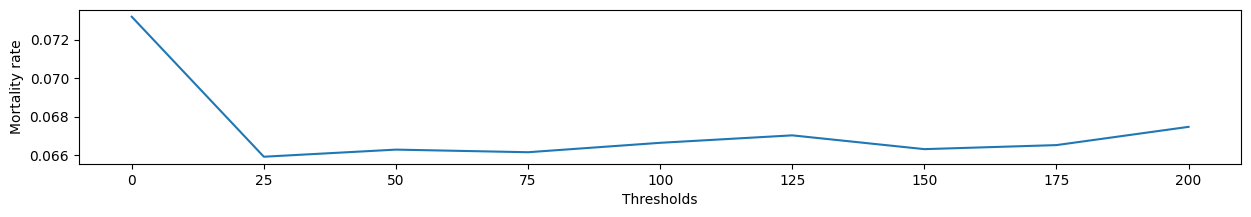

In [8]:
# optimizing under normal scenario
mortality_rates = np.zeros(len(thresholds))
idx = 0
for i, threshold in enumerate(thresholds):
    for _ in range(reps // 4):
        patients_hosp1_c = generate_patients(_hourly_arrival_rates, service_rate, patience, triage_probabilities, triage_probabilities_crisis, [1, 1, 1, 1], hosp_number=1)
        patients_hosp2_c = generate_patients(_hourly_arrival_rates, service_rate, patience, triage_probabilities, triage_probabilities_crisis, [1, 1, 1, 1], hosp_number=2)
        hosp1 = Hospital(_hourly_arrival_rates, service_rate, patience, triage_probabilities, triage_probabilities_crisis, [1, 1, 1, 1], threshold, days, patients_hosp1_c, hosp_number=1)
        hosp2 = Hospital(_hourly_arrival_rates, service_rate, patience, triage_probabilities, triage_probabilities_crisis, [1, 1, 1, 1], np.inf, days, patients_hosp2_c, doctor_shift_counts=hosp2_doctor_shift_counts[idx], hosp_number=2)
        simulate_system_by_shift(hosp1, hosp2, days, show_output=False, simulate_one_step_ahead=False, travel_time=travel_time_between_hospitals)
        mortality_rates[i] += np.mean([p.wait_time - p.death_time >= -1e-8 for p in hosp1.patients if not p.diverted] +
                                    [p.wait_time - p.death_time >= -1e-8 for p in hosp2.patients]) / (reps // 4)
best_threshold = thresholds[np.argmin(mortality_rates)]
print('Best Threshold:', best_threshold)

# applying best threshold to crisis scenario
patients_hosp1_c = loads(dumps(patients_hosp1[idx], -1))
patients_hosp2_c = loads(dumps(patients_hosp2[idx], -1))
hosp1 = Hospital(hourly_arrival_rates[idx], service_rate, patience, triage_probabilities, triage_probabilities_crisis, daily_crisis_factor[idx], best_threshold, days, patients_hosp1_c, hosp_number=1)
hosp2 = Hospital(hourly_arrival_rates[idx], service_rate, patience, triage_probabilities, triage_probabilities_crisis, daily_crisis_factor[idx], np.inf, days, patients_hosp2_c, doctor_shift_counts=hosp2_doctor_shift_counts[idx], hosp_number=2)
optimal_thresholds = simulate_system_by_shift(hosp1, hosp2, days, show_output=False, simulate_one_step_ahead=False, travel_time=travel_time_between_hospitals)
static_mortality_rate = np.mean([p.wait_time - p.death_time >= -1e-8 for p in hosp1.patients if not p.diverted] +
                                [p.wait_time - p.death_time >= -1e-8 for p in hosp2.patients])
print('Crisis Mortality Rate:', static_mortality_rate)

static_death_counts_h1 = get_patient_arrival_counts([p for p in hosp1.patients if not p.diverted and p.wait_time - p.death_time >= -1e-8])
static_death_counts_h2 = get_patient_arrival_counts([p for p in hosp2.patients if p.wait_time - p.death_time >= -1e-8])

plt.plot(thresholds, mortality_rates)
plt.xlabel('Thresholds')
plt.ylabel('Mortality rate')
plt.show()

##### Figure 6. Hourly arrival rate (solid curve) in the crisis scenario overlaid with the cumulative numbers (bars) of additional lives saved against hours using our AI-digital-twin integrated approach compared to the static policy.

In [46]:
######### this will take a considerable amount of time ######### 
skip = True
if not skip:
    hosp1 = Hospital(hourly_arrival_rates[idx], service_rate, patience, triage_probabilities, triage_probabilities_crisis, daily_crisis_factor[idx], 0., days, patients_hosp1[idx], hosp_number=1)
    hosp2 = Hospital(hourly_arrival_rates[idx], service_rate, patience, triage_probabilities, triage_probabilities_crisis, daily_crisis_factor[idx], np.inf, days, patients_hosp2[idx], doctor_shift_counts=hosp2_doctor_shift_counts[idx], hosp_number=2)
    optimal_thresholds = simulate_system_by_shift(
        hosp1, hosp2, days, show_output=True, simulate_one_step_ahead=True, 
        travel_time=travel_time_between_hospitals, previous_patient_counts_hosp1=_patients_hosp1_arrival_counts, 
        previous_patient_counts_hosp2=_patients_hosp2_arrival_counts
        )
    mortality_rate = np.mean([p.wait_time - p.death_time >= -1e-8 for p in hosp1.patients if not p.diverted] +
                                [p.wait_time - p.death_time >= -1e-8 for p in hosp2.patients])

    print('Crisis Mortality Rate (Data-Adaptive):', mortality_rate)

Crisis Mortality Rate (Data-Adaptive): 0.24355716878402903


In [9]:
hosp1 = Hospital(hourly_arrival_rates[idx], service_rate, patience, triage_probabilities, triage_probabilities_crisis, daily_crisis_factor[idx], best_threshold, days, patients_hosp1[idx], hosp_number=1)
hosp2 = Hospital(hourly_arrival_rates[idx], service_rate, patience, triage_probabilities, triage_probabilities_crisis, daily_crisis_factor[idx], np.inf, days, patients_hosp2[idx], doctor_shift_counts=hosp2_doctor_shift_counts[idx], hosp_number=2)
optimal_thresholds = simulate_system_by_shift(hosp1, hosp2, days, show_output=False, simulate_one_step_ahead=False, travel_time=travel_time_between_hospitals, threshold_model=threshold_model)
surrogate_mortality_rate = np.mean([p.wait_time - p.death_time >= -1e-8 for p in hosp1.patients if not p.diverted] +
                            [p.wait_time - p.death_time >= -1e-8 for p in hosp2.patients])
surrogate_death_counts_h1 = get_patient_arrival_counts([p for p in hosp1.patients if not p.diverted and p.wait_time - p.death_time >= -1e-8])
surrogate_death_counts_h2 = get_patient_arrival_counts([p for p in hosp2.patients if p.wait_time - p.death_time >= -1e-8])
print('Crisis Mortality Rate (AI-digital-twin):', surrogate_mortality_rate)

Crisis Mortality Rate (AI-digital-twin): 0.2471869328493648


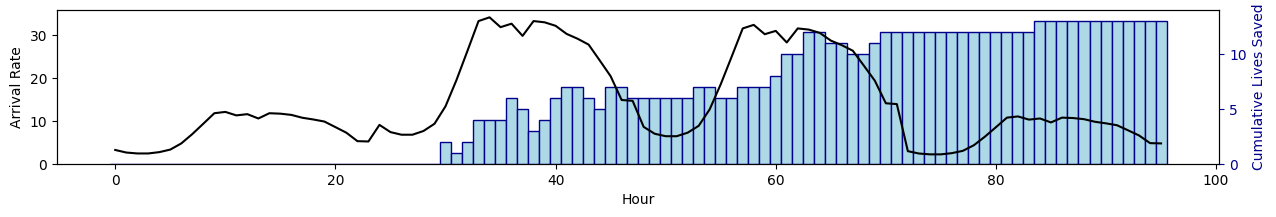

In [10]:
plot_arrival_overlay_lives(hourly_arrival_rates, static_death_counts_h1, static_death_counts_h2, surrogate_death_counts_h1, surrogate_death_counts_h2)